## Momento de retroalimentación - NLP 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!bash "/content/drive/MyDrive/7mo semestre/IA_2/environment_setup.sh"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.3 MB/s 
     |████████████████████████████████| 163 kB 75.6 MB/s 
     |████████████████████████████████| 7.6 MB 74.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 4.8 MB/s 
     |████████████████████████████████| 212 kB 80.9 MB/s 
     |████████████████████████████████| 95 kB 5.4 MB/s 
     |████████████████████████████████| 115 kB 78.7 MB/s 
     |████████████████████████████████| 127 kB 82.0 MB/s 
     |████████████████████████████████| 115 kB 80.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Un

In [ ]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

## Data analysis

In [4]:
import pandas as pd

In [6]:
train_data = pd.read_excel('/content/drive/MyDrive/7mo semestre/IA_2/twitter_dataset_train.xlsx')
test_data = pd.read_excel('/content/drive/MyDrive/7mo semestre/IA_2/twitter_dataset_dev.xlsx')
print("================= TRAIN DATA SAMPLE =================")
print(train_data.head())
print("================= TEST DATA sAMPLE =================")
print(test_data.head())

unique_data = pd.unique(train_data["LABEL"])
print("================= NUM OF LABELS =================")
print("num labels are: {n}".format(n = len(unique_data) - 1))
print("================= UNIQUE LABELS =================")
print(unique_data)

================= TRAIN DATA SAMPLE =================
              WORD LABEL
0  @SammieLynnsMom     O
1         @tg10781     O
2             they     O
3             will     O
4               be     O
================= TEST DATA sAMPLE =================
     WORD LABEL
0    STOP     O
1    WHAT     O
2  YOU'RE     O
3   DOING     O
4     AND     O
================= NUM OF LABELS =================
num labels are: 21
================= UNIQUE LABELS =================
['O' nan 'B-geo-loc' 'B-facility' 'I-facility' 'B-movie' 'I-movie'
 'B-company' 'B-product' 'B-person' 'B-sportsteam' 'I-sportsteam'
 'I-product' 'B-other' 'I-other' 'I-company' 'I-person' 'I-geo-loc'
 'B-tvshow' 'B-musicartist' 'I-musicartist' 'I-tvshow']


# Final code

In [ ]:
from datasets import Dataset, Features, Value, ClassLabel, Sequence
from transformers import BertTokenizer, BertForTokenClassification, Trainer, TrainerCallback, TrainingArguments, BertConfig, DataCollatorForTokenClassification
import pandas as pd
import numpy as np
import evaluate
import copy
import matplotlib.pyplot as plt

In [ ]:
class NERDataMaker:
    def __init__(self, tokens_with_entities_list):
        self.unique_entities = []
        self.processed_texts = []

        temp_processed_texts = []
        for tokens_with_entities in tokens_with_entities_list:            
            for _, ent in tokens_with_entities:
                if ent not in self.unique_entities:
                    self.unique_entities.append(ent)
            temp_processed_texts.append(tokens_with_entities)

        self.unique_entities.sort(key=lambda ent: ent if ent != "O" else "")

        for tokens_with_entities in temp_processed_texts:
            self.processed_texts.append([(t, self.unique_entities.index(ent)) for t, ent in tokens_with_entities]) # <- after this line classifier labels are converted into a numeric value

    @property
    def id2label(self):
        return dict(enumerate(self.unique_entities))

    @property
    def label2id(self):
        return {v:k for k, v in self.id2label.items()}

    def __len__(self):
        return len(self.processed_texts)

    def __getitem__(self, idx):
        def _process_tokens_for_one_text(id, tokens_with_encoded_entities):
            ner_tags = []
            tokens = []
            for t, ent in tokens_with_encoded_entities:
                ner_tags.append(ent)
                tokens.append(t)

            return {
                "id": id,
                "ner_tags": ner_tags,
                "tokens": tokens
            }

        tokens_with_encoded_entities = self.processed_texts[idx]
        if isinstance(idx, int):
            return _process_tokens_for_one_text(idx, tokens_with_encoded_entities)
        else:
            return [_process_tokens_for_one_text(i+idx.start, tee) for i, tee in enumerate(tokens_with_encoded_entities)]

    def string_starts_with(self, string, candidate_starting_substring):
      len_candidate = len(candidate_starting_substring)      
      return string[:len_candidate] == candidate_starting_substring

    def remove_starting_hastags(self, string):
      new_string = string
      for char in list(new_string):
        if char != "#":
          break
        else:
          new_string = new_string[1:]
      return new_string    

    def as_hf_dataset(self, tokenizer):
        def tokenize_and_align_labels(examples):
            original_words_list = examples["tokens"]
            labels_for_original_words_list = examples["ner_tags"]
            tokenized_inputs = tokenizer(original_words_list, truncation=True, is_split_into_words=True, padding = True)
            subwords_after_tokenizing = tokenizer.convert_ids_to_tokens(ids = tokenized_inputs["input_ids"])

            labels = []
            word_index = 0
            rebuilt_string = ""
            added_starting_label = False            
            for subword in subwords_after_tokenizing:            
              #special cases:              
              if subword is None or subword == "[CLS]" or subword == "[SEP]":
                labels.append(-100)
              else:
                if word_index < len(original_words_list):
                  rebuilt_string += self.remove_starting_hastags(subword)
                  if self.string_starts_with(original_words_list[word_index], subword) and not added_starting_label:
                    labels.append(labels_for_original_words_list[word_index])
                    added_starting_label = True
                  else:
                    labels.append(-100)
                  if rebuilt_string == self.remove_starting_hastags(original_words_list[word_index]):
                    word_index += 1
                    rebuilt_string = ""
                    added_starting_label = False                              

            tokenized_inputs["labels"] = labels
            return tokenized_inputs

        ids, ner_tags, tokens = [], [], []
        print("processed texts:")
        print(self.processed_texts[0])
        print("unique entities:")
        print(self.unique_entities)
        for i, pt in enumerate(self.processed_texts):
            ids.append(i)
            pt_tokens,pt_tags = list(zip(*pt))
            ner_tags.append(pt_tags)
            tokens.append(pt_tokens)
        data = {
            "id": ids,
            "ner_tags": ner_tags,
            "tokens": tokens
        }
        features = Features({
            "tokens": Sequence(Value("string")),
            "ner_tags": Sequence(ClassLabel(names=self.unique_entities)),
            "id": Value("int32")
        })
        ds = Dataset.from_dict(data, features)        
        tokenized_ds = ds.map(tokenize_and_align_labels, batched=False) # TODO: change this to true latter to achieve a batched behaiviour
        return tokenized_ds

In [ ]:
def create_tweets_with_entities_list(train_df):
  is_a_space = pd.isnull(train_df["WORD"])
  annotated_tweets = []
  annotated_tweet = []
  for indx in train_df.index:
    if is_a_space[indx]:
      if len(annotated_tweet) > 0:
        annotated_tweets.append( copy.deepcopy(annotated_tweet) )
      annotated_tweet = []
    else:
      annotated_tweet.append((train_df["WORD"][indx], train_df["LABEL"][indx])) 
  return annotated_tweets

In [ ]:
data_df = pd.read_excel("/content/drive/MyDrive/7mo semestre/IA_2/twitter_dataset_train.xlsx")

tweets_with_entities = create_tweets_with_entities_list(data_df)
num_entries = len(tweets_with_entities)
train_tweets_with_entities = tweets_with_entities[:int(num_entries*0.8)]
eval_tweets_with_entities = tweets_with_entities[int(num_entries*0.8):] 
training_data = NERDataMaker( train_tweets_with_entities )
eval_data = NERDataMaker( eval_tweets_with_entities )

print("trainig_data example:")
print(training_data[0])
tokenizer = BertTokenizer.from_pretrained("dslim/bert-base-NER")
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_data_prepared_for_hf_training = training_data.as_hf_dataset(tokenizer=tokenizer)
eval_data_prepared_for_hf_training = eval_data.as_hf_dataset(tokenizer=tokenizer)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--dslim--bert-base-NER/snapshots/f7c2808a659015eeb8828f3f809a2f1be67a2446/vocab.txt
loading file added_tokens.json from cache at /root/.cache/huggingface/hub/models--dslim--bert-base-NER/snapshots/f7c2808a659015eeb8828f3f809a2f1be67a2446/added_tokens.json
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--dslim--bert-base-NER/snapshots/f7c2808a659015eeb8828f3f809a2f1be67a2446/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--dslim--bert-base-NER/snapshots/f7c2808a659015eeb8828f3f809a2f1be67a2446/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--dslim--bert-base-NER/snapshots/f7c2808a659015eeb8828f3f809a2f1be67a2446/config.json
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassifi

trainig_data example:
{'id': 0, 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'tokens': ['@SammieLynnsMom', '@tg10781', 'they', 'will', 'be', 'all', 'done', 'by', 'Sunday', 'trust', 'me', '*wink*']}
processed texts:
[('@SammieLynnsMom', 0), ('@tg10781', 0), ('they', 0), ('will', 0), ('be', 0), ('all', 0), ('done', 0), ('by', 0), ('Sunday', 0), ('trust', 0), ('me', 0), ('*wink*', 0)]
unique entities:
['O', 'B-company', 'B-facility', 'B-geo-loc', 'B-movie', 'B-musicartist', 'B-other', 'B-person', 'B-product', 'B-sportsteam', 'B-tvshow', 'I-company', 'I-facility', 'I-geo-loc', 'I-movie', 'I-musicartist', 'I-other', 'I-person', 'I-product', 'I-sportsteam', 'I-tvshow']


  0%|          | 0/1583 [00:00<?, ?ex/s]

processed texts:
[('RT', 0), ('@RealJudgeJules', 0), (':', 0), ('Playing', 0), ('the', 0), ('world', 0), ('exclusive', 0), ('of', 0), ('@SanderVanDoorn', 0), ('remix', 0), ('of', 0), ('@swedishousemfia', 0), ('-', 0), ('Miami', 6), (2, 16), ('Ibiza', 16), ('on', 0), ('the', 0), ('show', 0), ('tonight', 0), ('.', 0), ('Tune', 0), ('i', 0), ('...', 0)]
unique entities:
['O', 'B-company', 'B-facility', 'B-geo-loc', 'B-movie', 'B-musicartist', 'B-other', 'B-person', 'B-product', 'B-sportsteam', 'B-tvshow', 'I-company', 'I-facility', 'I-geo-loc', 'I-movie', 'I-musicartist', 'I-other', 'I-person', 'I-product', 'I-sportsteam', 'I-tvshow']


  0%|          | 0/396 [00:00<?, ?ex/s]

In [ ]:
print("num labels to pass: {n}".format(n = len(training_data.unique_entities)))
#model_config = BertConfig.from_pretrained("dslim/bert-base-NER", num_labels=len(training_data.unique_entities))

model = BertForTokenClassification.from_pretrained("dslim/bert-base-NER",
                                                   ignore_mismatched_sizes=True,                                                   
                                                   _num_labels=len(training_data.unique_entities),                                                    
                                                   id2label=training_data.id2label, 
                                                   label2id=training_data.label2id)

training_arguments = TrainingArguments(output_dir = "/content/drive/MyDrive/7mo semestre/IA_2/NER_models",
                                      evaluation_strategy="epoch",
                                      logging_strategy="epoch",
                                      learning_rate=2e-5,
                                      per_device_train_batch_size=16,
                                      per_device_eval_batch_size=16,                                      
                                      num_train_epochs=40,
                                      weight_decay=0.01)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)    
    predictions = predictions.astype('int32')
    labels = labels.astype('int32')
    predictions = np.reshape(predictions, (predictions.shape[0]*predictions.shape[1],))
    labels = np.reshape(labels, (labels.shape[0]*labels.shape[1],))          
    return metric.compute(predictions=predictions, references=labels)    

trainer = Trainer(model = model,
                  args = training_arguments,
                  train_dataset=train_data_prepared_for_hf_training,
                  eval_dataset=eval_data_prepared_for_hf_training,
                  data_collator=data_collator,
                  compute_metrics = compute_metrics)

trainer.train()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--dslim--bert-base-NER/snapshots/f7c2808a659015eeb8828f3f809a2f1be67a2446/config.json
Model config BertConfig {
  "_num_labels": 21,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-company",
    "2": "B-facility",
    "3": "B-geo-loc",
    "4": "B-movie",
    "5": "B-musicartist",
    "6": "B-other",
    "7": "B-person",
    "8": "B-product",
    "9": "B-sportsteam",
    "10": "B-tvshow",
    "11": "I-company",
    "12": "I-facility",
    "13": "I-geo-loc",
    "14": "I-movie",
    "15": "I-musicartist",
    "16": "I-other",
    "17": "I-person",
    "18": "I-product",
    "19": "I-sportsteam",
    "20": "I-tvshow"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-compa

num labels to pass: 21


All model checkpoint weights were used when initializing BertForTokenClassification.

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([21, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([21]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForTokenClas

Epoch,Training Loss,Validation Loss,Accuracy
1,0.298200,0.153116,0.034673
2,0.120000,0.128871,0.034826
3,0.072900,0.135428,0.034905
4,0.047200,0.140708,0.034954
5,0.029300,0.151041,0.034816
6,0.018300,0.151739,0.034944
7,0.011600,0.154952,0.034944
8,0.007500,0.166009,0.034959
9,0.005700,0.165870,0.034949
10,0.004000,0.174380,0.034915


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens, id, ner_tags. If tokens, id, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 396
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens, id, ner_tags. If tokens, id, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 396
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens, id, ner_tags. If tokens, id, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Ru

TrainOutput(global_step=3960, training_loss=0.01643341738410821, metrics={'train_runtime': 10028.069, 'train_samples_per_second': 6.314, 'train_steps_per_second': 0.395, 'total_flos': 3599258852258190.0, 'train_loss': 0.01643341738410821, 'epoch': 40.0})

In [ ]:
trainer.state.log_history

[{'loss': 0.2982, 'learning_rate': 1.95e-05, 'epoch': 1.0, 'step': 99},
 {'eval_loss': 0.15311583876609802,
  'eval_accuracy': 0.034672900883838384,
  'eval_runtime': 16.4718,
  'eval_samples_per_second': 24.041,
  'eval_steps_per_second': 1.518,
  'epoch': 1.0,
  'step': 99},
 {'loss': 0.12, 'learning_rate': 1.9e-05, 'epoch': 2.0, 'step': 198},
 {'eval_loss': 0.1288713663816452,
  'eval_accuracy': 0.03482579703282828,
  'eval_runtime': 16.548,
  'eval_samples_per_second': 23.93,
  'eval_steps_per_second': 1.511,
  'epoch': 2.0,
  'step': 198},
 {'loss': 0.0729,
  'learning_rate': 1.8500000000000002e-05,
  'epoch': 3.0,
  'step': 297},
 {'eval_loss': 0.135427787899971,
  'eval_accuracy': 0.034904711174242424,
  'eval_runtime': 16.3621,
  'eval_samples_per_second': 24.202,
  'eval_steps_per_second': 1.528,
  'epoch': 3.0,
  'step': 297},
 {'loss': 0.0472, 'learning_rate': 1.8e-05, 'epoch': 4.0, 'step': 396},
 {'eval_loss': 0.14070773124694824,
  'eval_accuracy': 0.034954032512626264,
  

In [ ]:
# formating training results for plotting
raw_history = trainer.state.log_history[:-1]
training_metrics = {"eval_loss":[], "eval_accuracy": [], "loss":[]}
current_epoch = 1.0
for dictionary in raw_history:
  if dictionary["epoch"] != current_epoch:    
    current_epoch += 1.0
  metrics_in_dict = [i for i in training_metrics.keys() if i in dictionary.keys()]  
  for m in metrics_in_dict:
      training_metrics[m].append( (int(current_epoch),dictionary[m]) )
#training_metrics = {"eval_loss":training_metrics["eval_loss"], "eval_accuracy":training_metrics["eval_accuracy"], "train_loss":training_metrics["train_loss"]+training_metrics["loss"]}

for k in training_metrics:
  print( k + " " + str(training_metrics[k]) )

print("accuracy = {a}".format( a=list(zip(*training_metrics["eval_accuracy"]))[1] ))

eval_loss [(1, 0.15311583876609802), (2, 0.1288713663816452), (3, 0.135427787899971), (4, 0.14070773124694824), (5, 0.15104149281978607), (6, 0.15173925459384918), (7, 0.15495161712169647), (8, 0.16600850224494934), (9, 0.16587042808532715), (10, 0.17437955737113953), (11, 0.16134724020957947), (12, 0.16981524229049683), (13, 0.1789693385362625), (14, 0.18246249854564667), (15, 0.18364013731479645), (16, 0.18304122984409332), (17, 0.1879274845123291), (18, 0.1898173689842224), (19, 0.18941344320774078), (20, 0.19010570645332336), (21, 0.19218440353870392), (22, 0.19173628091812134), (23, 0.1934635490179062), (24, 0.19648750126361847), (25, 0.19918230175971985), (26, 0.19932058453559875), (27, 0.2019060105085373), (28, 0.20046134293079376), (29, 0.20582427084445953), (30, 0.20696982741355896), (31, 0.2072756439447403), (32, 0.2086413949728012), (33, 0.20918166637420654), (34, 0.20983585715293884), (35, 0.21058233082294464), (36, 0.2103072702884674), (37, 0.21058514714241028), (38, 0.210

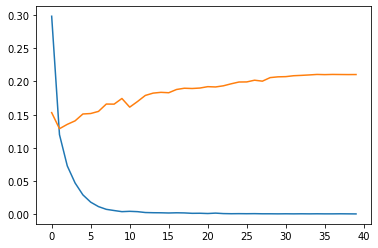

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(zip(*training_metrics["loss"]))[1], label="loss")
plt.plot(list(zip(*training_metrics["eval_loss"]))[1], label="val_loss")
#plt.plot(error, label="error")
plt.show()